In [1]:
import os
import pandas as pd
import numpy as np
from typing import List, Dict

from datacat4ml.const import FETCH_DATA_DIR
from datacat4ml.const import CAT_DATA_DIR, CAT_HHD_OR_DIR, CAT_MHD_OR_DIR, CAT_HHD_GPCR_DIR, CAT_MHD_GPCR_DIR # The LHD dirs are in the corresponding MHD dirs.
from datacat4ml.const import CURA_DATA_DIR, CURA_HHD_OR_DIR, CURA_MHD_OR_DIR, CURA_LHD_OR_DIR, CURA_HHD_GPCR_DIR, CURA_MHD_GPCR_DIR, CURA_LHD_GPCR_DIR
from datacat4ml.const import FEAT_DATA_DIR, FEAT_HHD_OR_DIR , FEAT_MHD_OR_DIR , FEAT_LHD_OR_DIR, FEAT_HHD_GPCR_DIR, FEAT_MHD_GPCR_DIR, FEAT_LHD_GPCR_DIR
from datacat4ml.const import SPLIT_DATA_DIR
from datacat4ml.const import CAT_FIG_DIR, CURA_FIG_DIR, FEAT_FIG_DIR
from datacat4ml.const import OR_chemblids_name

from datacat4ml.utils import mkdirs
from datacat4ml.Scripts.data_prep.data_featurize.feat_postproc import hhd_gpcr_failed, mhd_gpcr_failed

# ===================== plotting =====================
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import get_font_names
# Get a list of all available font names in alphabetical order
print(f"Available font names: \n{sorted(get_font_names())}")

from adjustText import adjust_text

#======================= RDKit =======================
from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS, Draw, PandasTools
from rdkit.Chem.Draw import MolsToGridImage
from IPython.display import display

#======================= t-SNE =======================

Available font names: 
['C059', 'Cantarell', 'D050000L', 'DejaVu Sans', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif Display', 'Droid Arabic Kufi', 'Droid Sans', 'Droid Sans Armenian', 'Droid Sans Devanagari', 'Droid Sans Ethiopic', 'Droid Sans Fallback', 'Droid Sans Georgian', 'Droid Sans Hebrew', 'Droid Sans Japanese', 'Droid Sans Tamil', 'Droid Sans Thai', 'Nimbus Mono PS', 'Nimbus Roman', 'Nimbus Sans', 'Nimbus Sans Narrow', 'P052', 'STIXGeneral', 'STIXNonUnicode', 'STIXSizeFiveSym', 'STIXSizeFourSym', 'STIXSizeOneSym', 'STIXSizeThreeSym', 'STIXSizeTwoSym', 'Source Code Pro', 'URW Bookman', 'URW Gothic', 'Z003', 'cmb10', 'cmex10', 'cmmi10', 'cmr10', 'cmss10', 'cmsy10', 'cmtt10']


# Stats files

## stats_df

In [2]:
#======================================================================
# read stats files
#======================================================================
def specify_col_dtypes(df:pd.DataFrame):
    # convert specified columns to appropriate data types
    cols_to_object = [
        # in both stats and dataset files
        'target_chembl_id', 'effect', 'assay', 'standard_type', 'assay_chembl_id', 
        # in stats files
        'ds_cat_level', 'ds_type', 'ds_size_level', 'use_lookup',
        
        # in dataset files
        'assay_id', 'tid', 'standard_relation', 'standard_units', 'assay_type', 'assay_type_description', 'assay_category',
        'assay_organism', 'assay_tax_id', 'assay_strain', 'assay_tissue', 'assay_cell_type', 'assay_subcellular_fraction',
        'bao_format', 'bao_label' , 'variant_id', 'assay_test_type', 'assay_description', 'cell_id', 'tissue_id',
        'curated_by', 'aidx', 'confidence_score', 'confidence_score_description', 'molregno', 'compound_chembl_id', 'canonical_smiles',
        'assay_metadata_hash', 'canonical_smiles_by_Std', 'activity_string', 'effect_description', 'assay_keywords_description'
        ]
    
    cols_to_int = [
        # in both stats and dataset files
        # in stats files
        'hhd_df', 'effect_type_df', 'plus_df', 'exclude_df', 'mhd_df', 'lhd_df', 
        'raw_size', 'curated_size', 'removed_size', 'feated_size', 'num_active', 'num_inactive', 'max_num_atoms',
        # in dataset files
        'num_atoms', 'activity', ''
        ]
    cols_to_float = [
        # in both stats and dataset files
        'threshold', 
        # in stats files
        '%_active', 'max_mw',
        # in dataset files
        'standard_value', 'pchembl_value', 'molecular_weight', 'pStandard_value', ''
        ]

    dtype_map = {
    **{col: object for col in cols_to_object},
    **{col: int for col in cols_to_int},
    **{col: float for col in cols_to_float},
    }

    for col, dtype in dtype_map.items():
        if col in df.columns:
            # only cast if not filled with "None"
            if dtype == int:
                df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)
            else:
                df[col] = df[col].astype(dtype)
    return df

def read_stats(in_path = CAT_DATA_DIR):
    """
    Read statistics data from CSV files and return as DataFrames.

    Params:
        in_path: Directory path where the stats files are located.
    
    Returns:
        dfs: Dictionary of DataFrames with filenames (without extension) as keys.
    """
    dfs = {}
    # files is a list of filenames ending with '_stats.csv' in the specified directory
    files = [f for f in os.listdir(in_path) if f.endswith('_stats.csv')]
    for f in files:
        df = pd.read_csv(os.path.join(in_path, f))

        # fill missing values in all columns with 'None'
        df = df.fillna('None')
        
        # specify column data types
        df = specify_col_dtypes(df)

        # store in dict
        dfs[f.split(".")[0]] = df
        print(f"{f}: {df.shape}")

    return dfs

cat_dfs = read_stats(in_path=CAT_DATA_DIR)
cura_dfs = read_stats(in_path=CURA_DATA_DIR)
feat_dfs = read_stats(in_path=FEAT_DATA_DIR)
#======================================================================
# merge the three stats files
#======================================================================
cura_feat_common_cols = ['ds_cat_level', 'ds_type', 'ds_size_level', 
                         'target_chembl_id', 'effect', 'assay', 'standard_type', 'assay_chembl_id']
all_common_cols =[c for c in cura_feat_common_cols if c != 'ds_size_level']

def merge_cat_cura_feat_stats(ds_cat_level='hhd', ds_type='or'):
    """
    Merge category, curated, and feature statistics DataFrames on common columns.

    Params:
        ds_cat_level: Dataset category level (e.g., 'hhd', 'mhd', 'lhd').
        ds_type: Dataset type (e.g., 'or', 'gpcr').

    Returns:
        merged_stats: Merged DataFrame containing statistics from all three sources.
    """

    key = f"{ds_cat_level}_{ds_type}_stats"

    merged_stats = pd.merge(
        cat_dfs[f"cat_{key}"],
        pd.merge(
            cura_dfs[f"cura_{key}"],
            feat_dfs[f"feat_{key}"],
            how='inner',
            on= cura_feat_common_cols
            ),
        how='outer', # due to cat_stats has some extra rows
        on=all_common_cols,
        )
    
    # specify column data types
    merged_stats = specify_col_dtypes(merged_stats)

    print(f'{key}: {merged_stats.shape}')
    return merged_stats

print("\n")
hhd_or_stats = merge_cat_cura_feat_stats(ds_cat_level='hhd', ds_type='or')
mhd_or_stats = merge_cat_cura_feat_stats(ds_cat_level='mhd', ds_type='or')
lhd_or_stats = merge_cat_cura_feat_stats(ds_cat_level='lhd', ds_type='or')
hhd_gpcr_stats = merge_cat_cura_feat_stats(ds_cat_level='hhd', ds_type='gpcr')
mhd_gpcr_stats = merge_cat_cura_feat_stats(ds_cat_level='mhd', ds_type='gpcr')
lhd_gpcr_stats = merge_cat_cura_feat_stats(ds_cat_level='lhd', ds_type='gpcr')

# ======================================================================
# concatenate 'or' and 'gpcr' stats
# ======================================================================
stats= pd.concat([hhd_or_stats, mhd_or_stats, lhd_or_stats,
                  hhd_gpcr_stats, mhd_gpcr_stats, lhd_gpcr_stats
                  ], ignore_index=True)

print(f'The shape of all stats: {stats.shape}\n')
print(f'The datatype for stats_df: \n{stats.dtypes}')

or_stats = stats[stats['ds_type'] == 'or']
gpcr_stats = stats[stats['ds_type'] == 'gpcr']

#======================================================================
# columns for plotting
#======================================================================
# categorical columns for a dataset
cat_ds_cols = ['ds_cat_level', 'ds_type', 'ds_size_level','use_lookup']
# categorical columns for an activity
cat_act_cols = ['target_chembl_id', 'effect', 'assay', 'standard_type', 'assay_chembl_id']

# numerical columns for a dataset
num_ds_cols = ['threshold', '%_active', 'feated_size', 'max_num_atoms', 'max_mw']

stats[cat_ds_cols + cat_act_cols].value_counts()

cat_hhd_gpcr_stats.csv: (688, 14)
cat_lhd_or_stats.csv: (35, 14)
cat_hhd_or_stats.csv: (12, 14)
cat_lhd_gpcr_stats.csv: (713, 14)
cat_mhd_or_stats.csv: (39, 14)
cat_mhd_gpcr_stats.csv: (1120, 14)
cura_hhd_or_stats.csv: (12, 15)
cura_lhd_or_stats.csv: (35, 15)
cura_hhd_gpcr_stats.csv: (634, 15)
cura_mhd_or_stats.csv: (38, 15)
cura_mhd_gpcr_stats.csv: (983, 15)
cura_lhd_gpcr_stats.csv: (696, 15)
feat_hhd_gpcr_stats.csv: (634, 11)
feat_mhd_or_stats.csv: (38, 11)
feat_lhd_or_stats.csv: (35, 11)
feat_hhd_or_stats.csv: (12, 11)
feat_mhd_gpcr_stats.csv: (983, 11)
feat_lhd_gpcr_stats.csv: (696, 11)


hhd_or_stats: (12, 25)
mhd_or_stats: (39, 25)
lhd_or_stats: (35, 25)
hhd_gpcr_stats: (688, 25)
mhd_gpcr_stats: (1120, 25)
lhd_gpcr_stats: (713, 25)
The shape of all stats: (2607, 25)

The datatype for stats_df: 
ds_cat_level         object
ds_type              object
use_lookup           object
target_chembl_id     object
effect               object
assay                object
standard_type       

ds_cat_level  ds_type  ds_size_level  use_lookup  target_chembl_id  effect  assay     standard_type  assay_chembl_id
hhd           gpcr     b50            None        CHEMBL1075101     None    None      EC50           None               1
mhd           gpcr     b50            False       CHEMBL234         agon    B-arrest  EC50           None               1
                                                                            G-cAMP    EC50           None               1
                                                                    antag   G-GTP     Ki             None               1
                                                                    bind    RBA       IC50           None               1
                                                                                                                       ..
lhd           gpcr     b50            False       CHEMBL219         bind    RBA       Ki             CHEMBL5250271      1
                             

## stats viz

### palette

In [3]:
#'ds_cat_level
hhd_color='#C4C3C3'
mhd_color= '#41BBB1'
lhd_color= '#235689'
ds_cat_level_palette = {"lhd":lhd_color, 
                    'mhd':mhd_color, 
                    'hhd':hhd_color}
# 'ds_type'
or_color='#03045e' # purple
gpcr_color='#677bab'  # light purple
ds_type_palette = {'or':or_color, 'gpcr':gpcr_color}

# target_chembl_id
mor_color = '#8B006B'
kor_color = '#538CBA'
dor_color = '#A5C93D'
nor_color = '#2000D7'
target_palette = {
    'CHEMBL233':mor_color,
    'CHEMBL237':kor_color,
    'CHEMBL236':dor_color,
    'CHEMBL2014':nor_color,
    }

# 'effect'
agon_color = '#f5426c'
antag_color = '#4278f5'
bind_color = '#b0e3e6'
effect_palette = {'agon':agon_color, 'antag':antag_color, 'bind':bind_color}

# 'assay' => style

# 'standard_type'
ki_color = ''
ic50_color = ''
ec50_color = ''

# standard_relation
less_color = '#03658c' # blue
greater_color = '#f29f05' # orange
equal_color = '#C4C3C3' # grey
standard_relation_palette = {'<':less_color, '<=':less_color, 
                             '>':greater_color, '>=':greater_color,
                             '=':equal_color}

# activity
one_color = '#8B006B' # i.e. active; dark red
zero_color = '#538CBA' # i.e. inactive; teal
activity_palette = {1:one_color, 0:zero_color}

### fetch viz

### categorization viz

#### effectwise
donut plot for effect-wise activity space

In [8]:
def effect_activity_space(stats_df=mhd_or_stats, target='CHEMBL233', startangle=-90, fig_format='pdf',
                        apply_bind_color= True, apply_agon_color=True, apply_antag_color=True,
                        n_bind_colors=2, n_agon_colors=5, n_antag_colors=3):

    target_len_df = stats_df[stats_df['target_chembl_id'] == target]
    outer_piece_column = 'feated_size'

    # extract coloums needed for plotting
    if stats_df is mhd_or_stats:
        
        target_len_df = target_len_df[['effect', 'assay', 'standard_type', outer_piece_column]]
        # create the pivot table
        target_len_df = pd.pivot_table(target_len_df, index=['effect','assay', 'standard_type'], values=[outer_piece_column])
        # sort the pivot table by the values of 'final_df' within each 'effect'
        target_len_df = target_len_df.sort_values(by=['effect', outer_piece_column], ascending=[True, True])
        # make a new column for labeling the minor data
        target_len_df['assay-type'] = target_len_df.index.get_level_values('assay') + ':' + target_len_df.index.get_level_values('standard_type')

        
        minor_labels = target_len_df['assay-type'] + '(' + target_len_df[outer_piece_column].astype(str) + ')'

    elif stats_df is lhd_or_stats:
        target_len_df = target_len_df[['effect', 'assay', 'standard_type', 'assay_chembl_id', outer_piece_column]]
        # create the pivot table
        target_len_df = pd.pivot_table(target_len_df, index=['effect','assay', 'standard_type', 'assay_chembl_id'], values=[outer_piece_column])
        # sort the pivot table by the values of 'final_df' within each 'effect'
        target_len_df = target_len_df.sort_values(by=['effect', outer_piece_column], ascending=[True, True])
        # make a new column for labeling the minor data
        target_len_df['assay-type-aid'] = target_len_df.index.get_level_values('assay') + ':' + target_len_df.index.get_level_values('standard_type') + ':' + target_len_df.index.get_level_values('assay_chembl_id')

        minor_labels = target_len_df['assay-type-aid'] + '(' + target_len_df[outer_piece_column].astype(str) + ')'

    ##########Plot the nested pie chart#####################
    # create a figure and subplots
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.3

    # data for pie charts
    # Major category values = sum of minor category values
    major_data = target_len_df.groupby('effect')[outer_piece_column].sum()
    major_labels = target_len_df.index.get_level_values('effect').unique()

    # Minor category values
    minor_data = target_len_df[outer_piece_column]

    # create custom colormaps based on a given color
    # color for major category
    major_colors = []
    minor_colors = []
    if apply_agon_color:
        major_colors.append(agon_color)
        # minor colors in the order of minor_data
        agon_palette = sns.light_palette(agon_color, n_colors=n_agon_colors)[::-1]

        for i in reversed(range(n_agon_colors)):
            minor_colors.append(agon_palette[i])

    if apply_antag_color:
        major_colors.append(antag_color)
        # minor colors in the order of minor_data
        antag_palette = sns.light_palette(antag_color, n_colors=n_antag_colors)[::-1]

        for i in reversed(range(n_antag_colors)):
            minor_colors.append(antag_palette[i])

    if apply_bind_color:
        major_colors.append(bind_color)
        # minor colors in the order of minor_data
        bind_palette = sns.light_palette(bind_color, n_colors=n_bind_colors)[::-1]

        for i in reversed(range(n_bind_colors)):
            minor_colors.append(bind_palette[i])


    # Draw pies
    hfont = {'fontname':'DejaVu Sans'}
    # pie for major category - 'effect', put in the inner circle
    ax.pie(major_data, 
        radius=1-width, 
        colors=major_colors,
        labels=major_labels,
        startangle=startangle,
        textprops={'fontsize': 13, 'fontweight':'bold', **hfont},
        wedgeprops=dict(width=width, edgecolor='w'),
        labeldistance=0.6)
    
    # pie for minor category - 'assay', put in the outer circle
    ax.pie(minor_data,
        radius=1,
        colors=minor_colors,
        labels=minor_labels,
        startangle=startangle,
        textprops={'fontsize': 11, **hfont},
        wedgeprops=dict(width=width, edgecolor='w'),
        labeldistance=1)

    # Set a title
    ax.set_title(f'{OR_chemblids_name[target]}: effect-wise activity space', fontsize=16, fontweight='bold', **hfont)

    # save the figure
    file_path = os.path.join(CAT_FIG_DIR)
    mkdirs(file_path)

    if stats_df is mhd_or_stats:
        fig.savefig(os.path.join(file_path, f"{target}_mhd_effect-wise_activity_space_pie.{fig_format}"), dpi=300, bbox_inches='tight')

    elif stats_df is lhd_or_stats:
        fig.savefig(os.path.join(file_path, f"{target}_lhd_effect-wise_activity_space_pie.{fig_format}"), dpi=300, bbox_inches='tight')
        
    return target_len_df

##### hhd -> mhd 

feated_size     assay-type
effect assay    standard_type                            
agon   B-arrest EC50                     0  B-arrest:EC50
       G-cAMP   EC50                     5    G-cAMP:EC50
       G-Ca     EC50                     9      G-Ca:EC50
       G-cAMP   IC50                    59    G-cAMP:IC50
       G-GTP    EC50                   187     G-GTP:EC50
antag  G-GTP    Ki                       6       G-GTP:Ki
                IC50                   120     G-GTP:IC50
bind   RBA      IC50                   416       RBA:IC50
                Ki                    1121         RBA:Ki

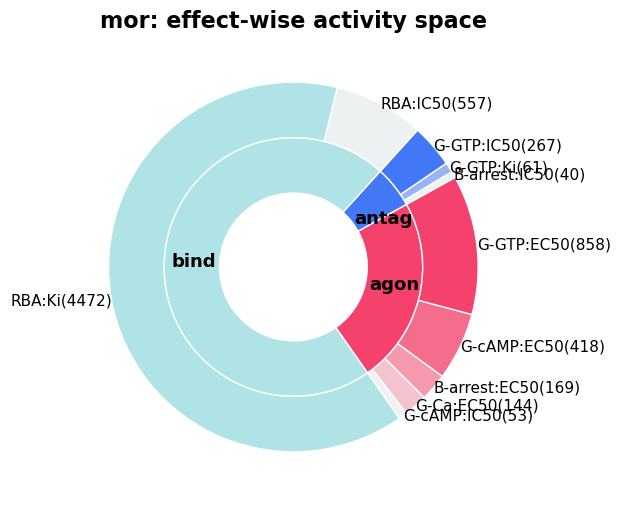

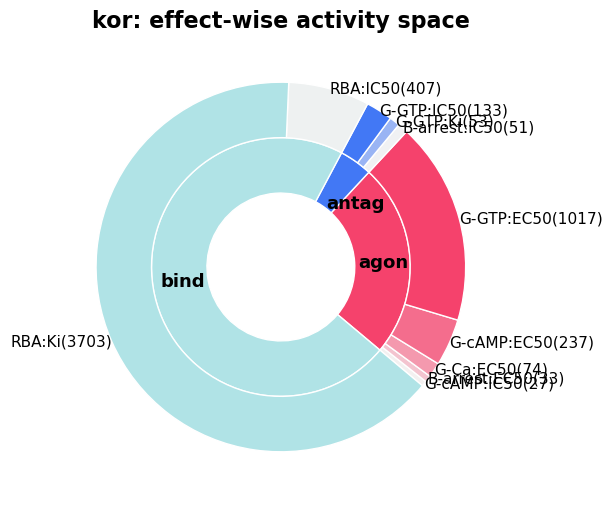

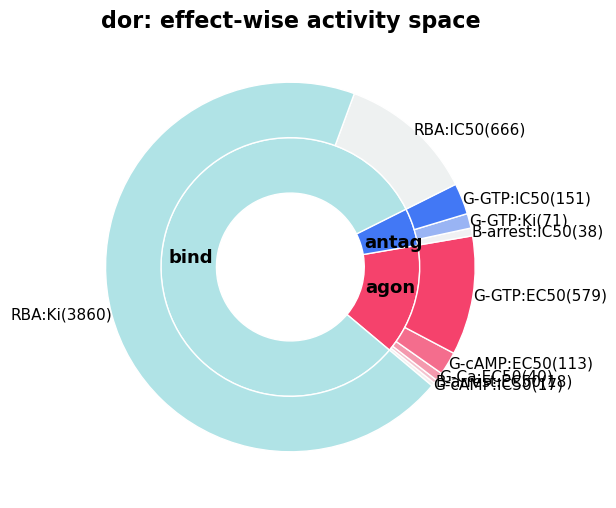

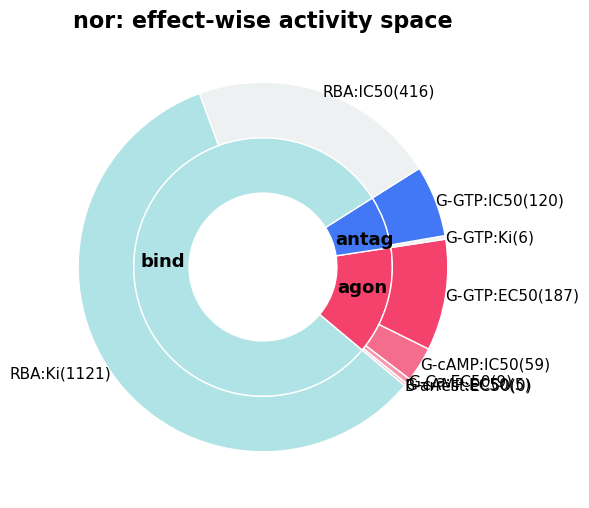

In [18]:
mor_h_mhd_df = effect_activity_space(stats_df=mhd_or_stats, target='CHEMBL233', startangle=-55, fig_format='pdf',
                                       n_bind_colors=2, n_agon_colors=5, n_antag_colors=3)
kor_h_mhd_df = effect_activity_space(stats_df=mhd_or_stats, target='CHEMBL237', startangle=-40, fig_format='pdf',
                                       n_bind_colors=2, n_agon_colors=5, n_antag_colors=3)
dor_h_mhd_df = effect_activity_space(stats_df=mhd_or_stats, target='CHEMBL236', startangle=-40, fig_format='pdf',
                                       n_bind_colors=2, n_agon_colors=5, n_antag_colors=3)
nor_h_mhd_df = effect_activity_space(stats_df=mhd_or_stats, target='CHEMBL2014', startangle=-40, fig_format='pdf',
                                       n_bind_colors=2, n_agon_colors=5, n_antag_colors=2)
mor_h_mhd_df
kor_h_mhd_df
dor_h_mhd_df
nor_h_mhd_df

##### mhd -> lhd 

feated_size         assay-type-aid
effect assay standard_type assay_chembl_id                                    
bind   RBA   Ki            CHEMBL888952              48    RBA:Ki:CHEMBL888952
                           CHEMBL3888830             51   RBA:Ki:CHEMBL3888830
                           CHEMBL892111              57    RBA:Ki:CHEMBL892111
                           CHEMBL1030622             68   RBA:Ki:CHEMBL1030622
             IC50          CHEMBL867087              69  RBA:IC50:CHEMBL867087

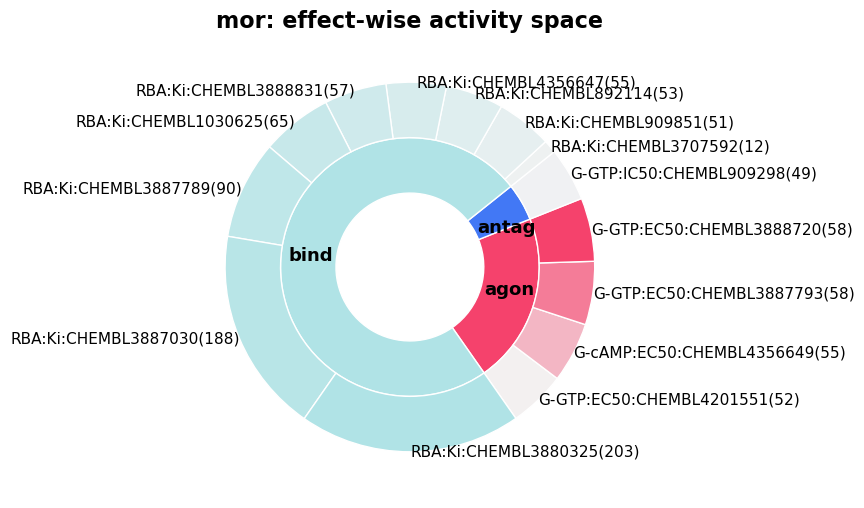

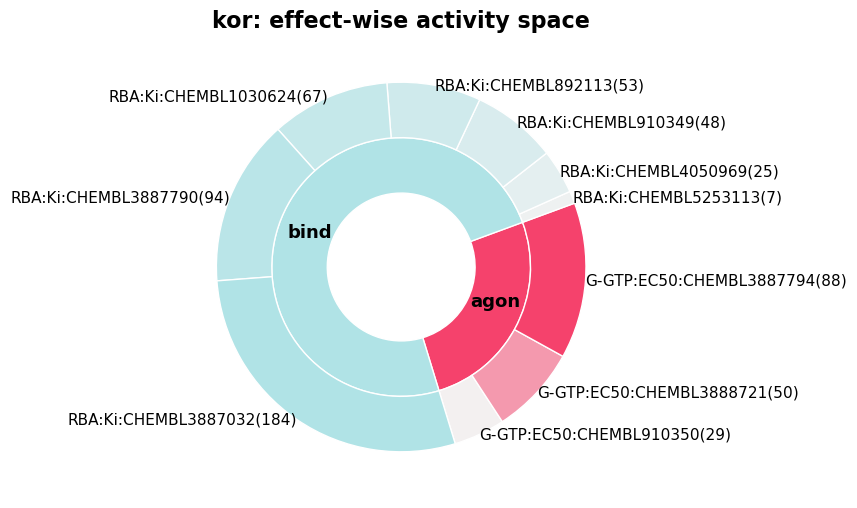

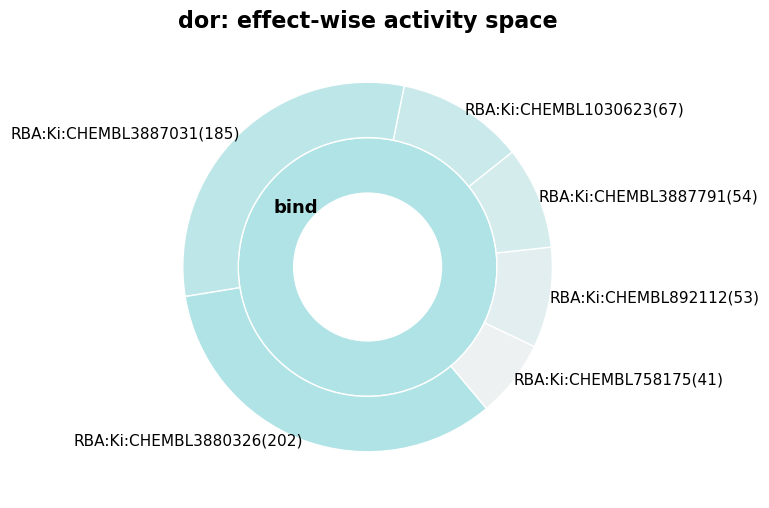

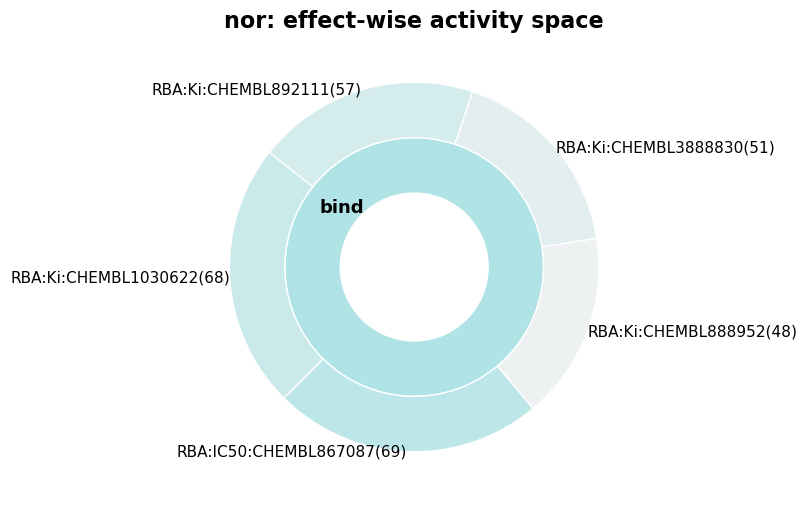

In [11]:
mor_m_lhd_df = effect_activity_space(stats_df=lhd_or_stats, target='CHEMBL233', startangle=-55, fig_format='pdf',
                                       n_bind_colors=9, n_agon_colors=4, n_antag_colors=1)
kor_m_lhd_df = effect_activity_space(stats_df=lhd_or_stats, target='CHEMBL237', startangle=-73, fig_format='pdf',
                                     apply_antag_color=False,
                                       n_bind_colors=7, n_agon_colors=3, n_antag_colors=0)
dor_m_lhd_df = effect_activity_space(stats_df=lhd_or_stats, target='CHEMBL236', startangle=-50, fig_format='pdf',
                                     apply_agon_color=False, apply_antag_color=False,
                                       n_bind_colors=6, n_agon_colors=0, n_antag_colors=0)
nor_m_lhd_df = effect_activity_space(stats_df=lhd_or_stats, target='CHEMBL2014', startangle=-50, fig_format='pdf',
                                     apply_agon_color=False, apply_antag_color=False,
                                       n_bind_colors=6, n_agon_colors=0, n_antag_colors=0)
mor_m_lhd_df
kor_m_lhd_df
dor_m_lhd_df
nor_m_lhd_df

#### Typewise => Yu:wait-to-do
donut plot for type-wise activity space

In [ ]:
def type_activity_space(target='CHEMBL233', startangle=-90, fig_format='pdf'):
    
    target_len_df = final_len_df[final_len_df['target'] == target]
    # extract columns needed for plotting
    target_len_df = target_len_df[['effect', 'assay', 'standard_type', 'final_df']]
    # create the pivot table
    target_len_df = pd.pivot_table(target_len_df, index=['standard_type', 'effect','assay'], values=['final_df'])
    # make a new column for labeling the minor data
    target_len_df['effect-assay'] = target_len_df.index.get_level_values('effect') + ': ' + target_len_df.index.get_level_values('assay')


    ##########Plot the nested pie chart#####################
    # create a figure and subplots
    fig, ax = plt.subplots(figsize=(10, 6))

    width = 0.3

    # data for pie charts
    # Major category values = sum of minor category values
    major_data = target_len_df.groupby('standard_type')['final_df'].sum()
    major_labels = target_len_df.index.get_level_values('standard_type').unique()
    # Minor category values
    minor_data = target_len_df['final_df']
    minor_labels = target_len_df['effect-assay'] + '(' + target_len_df['final_df'].astype(str) + ')'

    # create custom colormaps based on a given color
    # color for major category
    ec50_color = '#b0daff'
    ic50_color = '#19a7ce'
    kb_color = '#146c94'
    ke_color = '#164b60' 
    ki_color = '#c4b0ff' #'#e5beec', #f9f54b

    major_colors = [ec50_color, ic50_color, kb_color, ke_color, ki_color]
    # color for minor category
    ki_palette = sns.light_palette(ki_color, n_colors=2)[::-1]
    ic50_palette = sns.light_palette(ic50_color, n_colors=4)[::-1]
    ec50_palette = sns.light_palette(ec50_color, n_colors=4)[::-1]
    ke_palette = sns.light_palette(ke_color, n_colors=1)[::-1]
    kb_palette = sns.light_palette(kb_color, n_colors=1)[::-1]
    minor_colors = [ec50_palette[3], ec50_palette[2], ec50_palette[1], ec50_palette[0],
                    ic50_palette[3], ic50_palette[2], ic50_palette[1], ic50_palette[0],
                    kb_palette[0],
                    ke_palette[0],
                    ki_palette[1], ki_palette[0]]
    # Draw pies
    hfont = {'fontname':'serif'}
    # pie for major category - 'effect', put in the inner circle
    ax.pie(major_data, 
        radius=1-width, 
        colors=major_colors,
        labels=major_labels,
        startangle=startangle,
        textprops={'fontsize': 11, 'fontweight':'bold'},
        wedgeprops=dict(width=width, edgecolor='w'),
        labeldistance=0.65)
    # pie for minor category - 'assay', put in the outer circle
    ax.pie(minor_data,
        radius=1,
        colors=minor_colors,
        labels=minor_labels,
        startangle=startangle,
        textprops={'fontsize': 11, 'fontname':'serif'},
        wedgeprops=dict(width=width, edgecolor='w'),
        labeldistance=1)
    
    # Set a title
    ax.set_title(f'{target}: type-wise activity space', fontsize=16, fontweight='bold', **hfont)

    # save the figure
    file_path = os.path.join(CAT_FIG_DIR, target)
    mkdirs(file_path)

    fig.savefig(os.path.join(file_path, f"{target}_type-wise_activity_space_pie.{fig_format}"), dpi=300, bbox_inches='tight')
    print(f"Figure saved in {file_path}")
    
    return target_len_df

In [ ]:
#mor_type_len_df = type_activity_space(target='CHEMBL233', startangle=-90, fig_format='pdf')
#kor_type_len_df = type_activity_space(target='CHEMBL237', startangle=-103, fig_format='pdf')
#dor_type_len_df = type_activity_space(target='CHEMBL236', startangle=-101, fig_format='pdf')
#nor_type_len_df = type_activity_space(target='CHEMBL2014', startangle=-100, fig_format='pdf')

### curation viz

####  input: dataset stats
- 'threshold', 
- '%_active', 
- 'feated_size'
- 'max_num_atoms'
- 'max_mw'
- 'threshold' & '%_active'
- 'feated_size' & '%_active'

##### 'feated_size' & '%_active' -> replot

In [ ]:
def relplot(relplot_data:pd.DataFrame, x='feated_size', y='%_active',
            col='ds_cat_level', row='ds_type', 
            hue='ds_size_level', style=None):
        """
        """
        # font size for context.
        with sns.plotting_context("notebook", font_scale=2):

            g = sns.relplot(
                data=relplot_data, x=x, y=y,
                col=col, row=row, 
                hue=hue, style=style,
                s=200, # the dot size
                )
            # set the title for each subplot.
            g.set_titles(col_template="{col_name}", row_template="{row_name}") 

            # set the x and y axis.
            g.set(xlim=(0, relplot_data[x].max()+50),ylim=(0, 110), # the limits for x and y axes
                xscale='log' # set x axis to log scale
                )
            for ax in g.axes.flatten():
                sns.rugplot(data=relplot_data, x=x, ax=ax, alpha=0.3)
                sns.rugplot(data=relplot_data, y=y, ax=ax, alpha=0.3)

            # add horizontal reference lines at y=35 and y=65
            g.map(plt.axhline, y=35, color="grey", linestyle="--", linewidth=1) 
            g.map(plt.axhline, y=65, color="grey", linestyle="--", linewidth=1) 
            

        print(f'=============================')

        return g

#relplot(relplot_data=stats, hue='ds_size_level')

b50_stats = stats[stats['ds_size_level'] == 'b50']
#relplot(relplot_data=b50_stats, hue='use_lookup')

or_b50_stats = b50_stats[b50_stats['ds_type'] == 'or']
relplot(relplot_data=or_stats, row='ds_cat_level', col='target_chembl_id', hue='standard_type', style='effect')
relplot(relplot_data=gpcr_stats, row='ds_cat_level', col='assay', hue='standard_type', style='effect')
#relplot(relplot_data=or_b50_stats, row='ds_cat_level', col='target_chembl_id', hue='standard_type', style='assay')
#relplot(relplot_data=or_b50_stats, row='ds_cat_level', col='target_chembl_id', hue='standard_type', style='assay_chembl_id')

##### singles -> hisplot

In [ ]:
def histplot(df=or_stats, ds_type='or', x='threshold'):

    with sns.plotting_context("notebook", font_scale=1):
        # initialize the fig
        plt.figure(figsize=(4, 2))
        plt.rcParams["font.family"] = "DejaVu Sans"
    
        # set color based on ds_type
        if ds_type == 'or':
            color = or_color
        elif ds_type == 'gpcr':
            color = gpcr_color
    
        binrange=(df[x].min(), df[x].max())
        # plot a hisgram of 'threshold'
        sns.histplot(data=df, 
                     x=x, 
                     color=color, 
                     kde=True, 
                     binrange=binrange,
                     linewidth=0 # remove the border line
                     )
        
        # font size for context.
        sns.set_context("notebook", font_scale=1) 
        
        # set x, y and title
        if x == 'threshold':
            plt.xticks(ticks=plt.xticks()[0], labels=[f'{x:.1f}' for x in plt.xticks()[0]]) # set the decimal places of x-axis ticks to 1
        if x == 'feated_size':
            plt.xscale('log') # set x axis to log scale
        plt.title(f'{ds_type.upper()}')
    
        # save the figure
        plt.savefig(os.path.join(CURA_FIG_DIR, f'threshold_distribution_{ds_type.upper()}.pdf'), dpi=300, bbox_inches='tight')


# 'threshold'
histplot(df=or_stats, ds_type='or', x='threshold')
histplot(df=gpcr_stats, ds_type='gpcr', x='threshold')

# '%_active'
histplot(df=or_stats, ds_type='or', x='%_active')
histplot(df=gpcr_stats, ds_type='gpcr', x='%_active')

# 'feated_size'
histplot(df=or_stats, ds_type='or', x='feated_size')
histplot(df=gpcr_stats, ds_type='gpcr', x='feated_size')

# 'max_num_atoms'
histplot(df=or_stats, ds_type='or', x='max_num_atoms')
histplot(df=gpcr_stats, ds_type='gpcr', x='max_num_atoms')

# 'max_mw'
histplot(df=or_stats, ds_type='or', x='max_mw')
histplot(df=gpcr_stats, ds_type='gpcr', x='max_mw')

##### singles -> histplot_hue

In [ ]:
def histplot_hue(df, ds_type='or', x='%_active'):

    with sns.plotting_context("notebook", font_scale=1):
        # initialize the fig
        plt.figure(figsize=(4,2))
        plt.rcParams["font.family"] = "DejaVu Sans"

        # plot a histgram
        sns.histplot(
            data=df,
            x=x,
            hue="ds_cat_level",        # groups by ds_cat_level
            multiple="dodge",      # "dodge" (not suitable for too many hue levels); "stack" for stacked; "layer" for overlay; "fill" for filled; 
            bins=20,
            palette=ds_cat_level_palette,
            linewidth=0 # remove the border line
        )
        
        # set x, y and title
        if x == 'threshold':
            plt.xticks(ticks=plt.xticks()[0], labels=[f'{x:.1f}' for x in plt.xticks()[0]]) # set the decimal places of x-axis ticks to 1
        if x == 'feated_size':
            plt.xscale('log') # set x axis to log scale
        plt.title(f'{ds_type.upper()}')

        # save the figure
        if ds_type == 'or':
            plt.savefig(os.path.join(CURA_FIG_DIR, 'active_ratio_distribution_OR.pdf'), dpi=300, bbox_inches='tight')
        elif ds_type == 'gpcr':
            plt.savefig(os.path.join(CURA_FIG_DIR, 'active_ratio_distribution_GPCR.pdf'), dpi=300, bbox_inches='tight')


# threshold
histplot_hue(df=or_stats, ds_type='or', x='threshold')
histplot_hue(df=gpcr_stats, ds_type='gpcr', x='threshold')
# %_active
histplot_hue(df=or_stats, ds_type='or', x='%_active' )
histplot_hue(df=gpcr_stats, ds_type='gpcr', x='%_active')
# feated_size
histplot_hue(df=or_stats, ds_type='or', x='feated_size')
histplot_hue(df=gpcr_stats, ds_type='gpcr', x='feated_size')
# max_num_atoms
histplot_hue(df=or_stats, ds_type='or', x='max_num_atoms')
histplot_hue(df=gpcr_stats, ds_type='gpcr', x='max_num_atoms')
# max_mw
histplot_hue(df=or_stats, ds_type='or', x='max_mw')
histplot_hue(df=gpcr_stats, ds_type='gpcr', x='max_mw')

####  input: cols in a dataset

- 'molecular_weight',
- 'num_atoms'
- 'pStandard_value'
- 'activity_string'
- 'activity'

##### 'activity' % 'pStandard_value' -> swarmplot 

In [ ]:
def dir_swarmplots(in_path=FEAT_HHD_OR_DIR, x='activity', y='pStandard_value',
                   hue='standard_relation', concat=False):
    """
    Generate swarmplots either for concatenated data (concat=True)
    or for each file separately (concat=False).
    """

    def plot_swarmplot(df, title, figsize=(4,2)):
        with sns.plotting_context("notebook", font_scale=1.2):
            plt.figure(figsize=figsize)
            g = sns.swarmplot(
                data=df, x=x, y=y,
                hue=hue, palette=standard_relation_palette,
                s=3, legend=False
            )
            # set y limits
            g.set(ylim=(df[y].min(), df[y].max()))

            # reference lines
            plt.axhline(y=df['threshold'].iloc[0], color="black", linestyle="--", linewidth=2, label='threshold')
            plt.title(title)

            plt.show()

    if concat:
        concat_df = pd.DataFrame()
        for f in os.listdir(os.path.join(in_path, 'all')):
            df = pd.read_pickle(os.path.join(in_path, 'all', f))
            df = specify_col_dtypes(df)
            concat_df = pd.concat([concat_df, df], ignore_index=True)

        print(f"The shape of concatenated df from {in_path}: {concat_df.shape}")
        title = in_path.split('/')[-1].replace('feat_', '').upper()
        plot_swarmplot(concat_df, title, figsize=(6,4))

    else:
        for f in os.listdir(os.path.join(in_path, 'all')):
            df = pd.read_pickle(os.path.join(in_path, 'all', f))
            df = specify_col_dtypes(df)
            plot_swarmplot(df, f.replace('_featurized.pkl', ''))

In [ ]:
#dir_swarmplots(in_path=FEAT_LHD_OR_DIR, x='activity', y='pStandard_value', hue='standard_relation', concat=True)
dir_swarmplots(in_path=FEAT_MHD_OR_DIR, x='activity', y='pStandard_value', hue='standard_relation', concat=True)
#dir_swarmplots(in_path=FEAT_HHD_OR_DIR, x='activity', y='pStandard_value', hue='standard_relation', concat=True)

#dir_swarmplots(in_path=FEAT_LHD_OR_DIR, x='activity', y='pStandard_value', hue='standard_relation', concat=False)
#dir_swarmplots(in_path=FEAT_MHD_OR_DIR, x='activity', y='pStandard_value', hue='standard_relation', concat=False)
#dir_swarmplots(in_path=FEAT_HHD_OR_DIR, x='activity', y='pStandard_value', hue='standard_relation', concat=False)

##### 'molecular_weight'
##### 'num_atoms'


In [ ]:
#if ds_cat_level == 'hhd':
#        basename = f'{target}_{std_type}'
#elif ds_cat_level == 'mhd':
#        basename = f'{target}_{effect}_{assay}_{std_type}'
#elif ds_cat_level == 'lhd':
#        basename = f'{target}_{effect}_{assay}_{std_type}_{assay_chembl_id}'

#### before

In [ ]:
# initialize the fig
plt.figure(figsize=(4,3))
plt.rcParams["font.family"] = "DejaVu Sans"

# set color palette
ds_level_palette = {"'lhd'":'#235689', 
                    'mhd':'#41BBB1', 
                    'hhd':'#C4C3C3'}
# plot a heatmap
curated_size = df.pivot(index=["ds_level", "target", "effect", "assay", "assay_chembl_id"], columns=["standard_type"], values="curated_size")
curated_size = curated_size.apply(pd.to_numeric, errors="coerce")
#sns.heatmap(curated_size, annot=True, fmt="d", cmap="YlGnBu", cbar=False, linewidths=.5, linecolor='gray')
sns.heatmap(curated_size, annot=True)

### featurization viz

In [ ]:
# PCA
# t-SNE 2

In [12]:
from sklearn.manifold import TSNE
import numpy as np

feat_hhd_or_f1 = pd.read_pickle(os.path.join(FEAT_MHD_OR_DIR, 'all', 'CHEMBL237_antag_G-GTP_Ki_mhd_b50_featurized.pkl'))
df = feat_hhd_or_f1
print(f"The shape of df: {df.shape}")

X = np.vstack(df["PHARM2D"].values)
print(f"The shape of X: {X.shape}")
X

The shape of df: (53, 57)
The shape of X: (53, 39972)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
X.any(axis=0)

array([False, False, False, ..., False, False, False])

In [ ]:
# Concatenate features along axis 0 (stack samples on top of each other)
X_combined = np.vstack([X4, X6])     # shape (2n, d)
print("Combined shape:", X_combined.shape)

# Run one t-SNE
X_tsne = TSNE(n_components=2, random_state=42, perplexity=2).fit_transform(X_combined)

# Split back into ECFP4 and ECFP6 parts
n = len(df)
X4_tsne, X6_tsne = X_tsne[:n], X_tsne[n:]

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(X4_tsne[:, 0], X4_tsne[:, 1], c='blue', s=5, label='ECFP4')
plt.scatter(X6_tsne[:, 0], X6_tsne[:, 1], c='red', s=5, label='ECFP6')
plt.legend()
plt.title("Joint t-SNE of ECFP4 and ECFP6")
plt.show()

# Fetch

In [ ]:
# Greg's maxcurated dataset
Ki_maxcur_path = os.path.join(FETCH_DATA_DIR, 'Ki_maxcur')
IC50_maxcur_path = os.path.join(FETCH_DATA_DIR, 'IC50_maxcur')
EC50_maxcur_path = os.path.join(FETCH_DATA_DIR, 'EC50_maxcur')

The files (greg_max_file) in each above path seems like lhd_gpcr in my workflow, but not exactly.
- Firstly, the grep_max_file is not categorized based on the `patter_regex` I used later
- Secondly, the grep_max_file is not further categorized based on `EFFECT_TYPE_LOOKUP` I used later.
- Thirdly, the number of data points in each greg_max_file is > 100, but lhd_gpcr files can be as small as the data points exists after data curation.

In [ ]:
# All datapoints after maxcuration are stored in above 3 dataframes.
ki_gpcr_df = pd.read_csv(os.path.join(FETCH_DATA_DIR, 'Ki_gpcr_maxcur_8_data.csv'))
ic50_gpcr_df = pd.read_csv(os.path.join(FETCH_DATA_DIR, 'IC50_gpcr_maxcur_8_data.csv'))
ec50_gpcr_df = pd.read_csv(os.path.join(FETCH_DATA_DIR, 'EC50_gpcr_maxcur_8_data.csv'))

## assay_info_hash
assay_info_hash cannot distinguish different assays.

# Categorization

## categorized datasets

In [ ]:
cat_hhd_or_df = pd.read_csv(os.path.join(CAT_HHD_OR_DIR, 'CHEMBL233', 'Ki', 'CHEMBL233_Ki_hhd_df.csv'))
print(f'The columns in cat_hhd_or_df: \n{cat_hhd_or_df.columns}\n')

cat_hhd_or_df

# Curation

## curated datasets

In [ ]:
cura_lhd_or_f = pd.read_csv(os.path.join(CURA_DATA_DIR, 'cura_lhd_or', 'CHEMBL233_bind_RBA_Ki_CHEMBL3887789_lhd_b50_curated.csv'))
cura_lhd_or_f_smi = cura_lhd_or_f[['target_chembl_id', 'effect', 'assay', 'std_type', 'assay_chembl_id', 'canonical_smiles', 'canonical_smiles_by_Std']]
cura_lhd_or_f.drop(columns=["Unnamed: 0"], inplace=True)
#cura_lhd_or_f.columns()
#12
cura_lhd_or_f.iloc[:, -13:]

### 2D structure of SMILES before and after curation

In [ ]:
def display_2d_in_df(df, slice_start=0, slice_end=10):
    """ display the 2D structure of column 'canonical_smiles' and 'canonnical_smiles_by_Std' using rdkit"""

    

    print(f"The shape of the dataframe: {df.shape}")

    df = df.copy()[slice_start:slice_end] 

    # Convert SMILES strings to RDKit molecule objects
    df['before_cura'] = df['canonical_smiles'].apply(Chem.MolFromSmiles)
    df['after_cura'] = df['canonical_smiles_by_Std'].apply(Chem.MolFromSmiles)

    PandasTools.AddMoleculeColumnToFrame(df, "canonical_smiles", "before_cura", includeFingerprints=False)
    PandasTools.AddMoleculeColumnToFrame(df, "canonical_smiles_by_Std", "after_cura", includeFingerprints=False)

    # Display the DataFrame
    display(df)

#display_2d_in_df(df = cura_lhd_or_f_smi, slice_start=70, slice_end=90)

### all numeric columns

In [ ]:
# The data type of each column
num_cols_4each_file = ['max_molecular_weight', 'max_num_atoms', 'threshold']
num_cols_4each_comp = ['molecular_weight', 'num_atoms', 'pStandard_value', 'activity']

#### 'molecular_weight'

In [ ]:
def histplot_MW(ds_df, ds_type='or'):

    # initialize the fig
    plt.figure(figsize=(4, 2))
    plt.rcParams["font.family"] = "DejaVu Sans"

    # set color based on ds_type
    if ds_type == 'or':
        color = '#03045e' # purple
    elif ds_type == 'gpcr':
        color = '#677bab'  # light purple

    # plot a hisgram of 'molecular_weight'
    sns.displot(data=ds_df, 
                x='pStandard_value', 
                color=color, 
                kde=True, 
                binrange=(4, 6),
                linewidth=0 # remove the border line
                )
    
    # set x, y and title
    plt.xticks(ticks=plt.xticks()[0], labels=[f'{x:.1f}' for x in plt.xticks()[0]]) # set the decimal places of x-axis ticks to 1
    plt.xlabel('Molecular Weight')
    plt.title(f'Molecular Weight Distribution ({ds_type.upper()})')

    # save the figure
    plt.savefig(os.path.join(CURA_FIG_DIR, f'molecular_weight_distribution_{ds_type.upper()}.pdf'), dpi=300, bbox_inches='tight')

histplot_MW(ds_df=cura_lhd_or_f, ds_type='or')

# Featurization

## SMILES Failed to be embedded
Some SMILES Failed to be embedded by rdkit for 3D descriptor calculation

### Skip embedding these SMILES

In [ ]:
from datacat4ml.Scripts.data_prep.data_featurize.feat_smi_list import Featurizer
in_dir = CURA_HHD_GPCR_DIR
#descriptor = "SHAPE3D"
descriptor = "AUTOCORR3D"

# initiate featurizer
featurizer = Featurizer()
curated_f = pd.read_csv(os.path.join(in_dir, "CHEMBL5850_EC50_hhd_b50_curated.csv")).drop(columns=['Unnamed: 0'], errors='ignore')
print(f'The shape of curated_f: {curated_f.shape}')

curated_f_20_27 = curated_f.iloc[20:27, :]
print(f'The shape of curated_f_20_27: {curated_f_20_27.shape}')
curated_f_20_27.iloc[:, -13:]

print(f'The columns in curated_f_20_27: \n{curated_f_20_27.columns}\n')
display_2d_in_df(df = curated_f_20_27, slice_start=0, slice_end=7)

In [ ]:
smi_list = curated_f_20_27['canonical_smiles_by_Std'].to_list()
descriptor_array = featurizer(descriptor, smi=smi_list)
## append featurized data of each descriptor as a new column to the dataframe
curated_f_20_27[descriptor] = [arr for arr in descriptor_array]

In [ ]:
print(f"The length of 0: {len(curated_f_20_27['AUTOCORR3D'].iloc[0])}")
curated_f_20_27['AUTOCORR3D'].iloc[0]

In [ ]:
print(f"The length of 6: {len(curated_f_20_27['AUTOCORR3D'].iloc[6])}")
curated_f_20_27['AUTOCORR3D'].iloc[6]

### Display these SMILES

In [ ]:
def display_2d_smi(failed_smis: List[str], 
                   save_path: str = None):

    failed_mols = [Chem.MolFromSmiles(smi) for smi in failed_smis]

    # Highlight the specified substructure (e.g., norbornane) of each molecule in the grid image
    norbornane_smarts = 'C1C[C@]2CC[C@@]1C2'
    norbornane_mol = Chem.MolFromSmarts(norbornane_smarts)
    highlight_indices = [mol.GetSubstructMatch(norbornane_mol) for mol in failed_mols]

    # Create a single grid image of all molecules
    grid_image = MolsToGridImage(failed_mols,
                                 #highlightAtomLists=highlight_indices,
                                 molsPerRow=3,
                                 subImgSize=(250, 100),
                                 useSVG=True
                                 )

    if save_path:
        with open(os.path.join(save_path, "Failed_SMILES_2D.svg"), 'w') as f_handle:
            f_handle.write(grid_image.data)
    display(grid_image)

In [ ]:
unique_failed_smis = []
for file, failed_dict in hhd_gpcr_failed.items():
    for idx, smi in failed_dict.items():
        if smi not in unique_failed_smis:
            unique_failed_smis.append(smi)
for file, failed_dict in mhd_gpcr_failed.items():
    for idx, smi in failed_dict.items():
        if smi not in unique_failed_smis:
            unique_failed_smis.append(smi)
print(f'The total number of unique failed SMILES: {len(unique_failed_smis)}')

display_2d_smi(unique_failed_smis, save_path=FEAT_FIG_DIR)

## Featurized datasets

In [ ]:
ds_cat_level = 'hhd'
ds_type = 'or'
in_path = os.path.join(FEAT_HHD_OR_DIR, 'all')


###
feat_files = [f for f in os.listdir(in_path)]

feat_dfs = {}
for f in feat_files[:1]:
    print(f'f is {f}')

    if ds_cat_level == 'hhd':
        effect, assay, assay_chembl_id = None, None, None
        target, standard_type, ds_cat_level, ds_size_level = f.split('_')[:4]
        use_lookup = False
    elif ds_cat_level == 'mhd':
        assay_chembl_id = None
        target, effect, assay, standard_type, ds_cat_level, ds_size_level = f.split('_')[:6]
        if ds_type == 'or':
            use_lookup = True
        elif ds_type == 'gpcr':
            use_lookup = False
    elif ds_cat_level == 'lhd':
        target, effect, assay, standard_type, assay_chembl_id, ds_cat_level, ds_size_level = f.split('_')[:7]
        if ds_type == 'or':
            use_lookup = True
        elif ds_type == 'gpcr':
            use_lookup = False

    #
    cat_hhd_df = pd.read_csv(os.path.join(CAT_HHD_OR_DIR, 'cat_hhd_or_dfs_len.csv'))

    # print
    print(f'ds_cat_level is {ds_cat_level},\n'
          f'use_lookup is {use_lookup},\n'

          f'target is {target},\n' 
          f'effect is {effect},\n'
          f'assay is {assay},\n'
          f'standard_type is {standard_type},\n'
          f'assay_chembl_id is {assay_chembl_id},\n'

          f'ds_size_level is {ds_size_level}')

    
    df = pd.read_pickle(os.path.join(in_path, f))
    print(f'The shape of {f}: {df.shape}')
    #feat_dfs[f] = df

In [ ]:
CHEMBL233_Ki_hhd_b50_feat = feat_dfs['CHEMBL233_Ki_hhd_b50_featurized.pkl']
CHEMBL233_Ki_hhd_b50_feat.head()

### Indivisual pkl files

In [ ]:
feat_hhd_or_f1 = pd.read_pickle(os.path.join(FEAT_HHD_OR_DIR, 'all', 'CHEMBL237_EC50_hhd_b50_featurized.pkl'))
print(f'The shape of feat_hhd_or_f1: {feat_hhd_or_f1.shape}')
print(f'The columns in feat.pkl: \n{feat_hhd_or_f1.columns}\n')
# the last 13 columns are the features
feat_hhd_or_f1.iloc[:, -13:].head(1)
feat_hhd_or_f1['standard_relation'].value_counts()

In [ ]:
feat_mhd_or_f1 = pd.read_pickle(os.path.join(FEAT_MHD_OR_DIR, 'all', 'CHEMBL233_bind_RBA_Ki_mhd_b50_featurized.pkl'))
print(f'The shape of feat_mhd_or_f1: {feat_mhd_or_f1.shape}')
print(f'The columns in feat.pkl: \n{feat_mhd_or_f1.columns}\n')

In [ ]:
feat_lhd_or_f1 = pd.read_pickle(os.path.join(FEAT_LHD_OR_DIR, 'all', 'CHEMBL233_bind_RBA_Ki_CHEMBL1030625_lhd_b50_featurized.pkl'))
print(f'The shape of feat_lhd_or_f1: {feat_lhd_or_f1.shape}')
print(f'The columns in feat.pkl: \n{feat_lhd_or_f1.columns}\n')

In [ ]:
df = feat_mhd_or_f1

df[['pchembl_value', 'pStandard_value']]
#df[df['standard_relation'] != '=']
df['pchembl_value'].isna().sum()

df[['confidence_score', 'confidence_score_description']]

### Featurization stats

## Encode

In [ ]:
compound_names_df = pd.read_parquet(os.path.join(SPLIT_DATA_DIR, 'fsmol_alike', 'MHDsFold', 'compound_names.parquet'))
compound_smiles_df = pd.read_parquet(os.path.join(SPLIT_DATA_DIR, 'fsmol_alike', 'MHDsFold', 'compound_smiles.parquet'))
activity_df = pd.read_parquet(os.path.join(SPLIT_DATA_DIR, 'fsmol_alike', 'MHDsFold', 'activity.parquet'))
assay_info_df = pd.read_parquet(os.path.join(SPLIT_DATA_DIR, 'fsmol_alike', 'MHDsFold', 'assay_info.parquet'))
print(f'The shape of compound_names_df: {compound_names_df.shape}\n'
      f'compound_names_df.columns: {compound_names_df.columns}\n'
      f'The shape of compound_smiles_df: {compound_smiles_df.shape}\n'
      f'compound_smiles_df.columns: {compound_smiles_df.columns}\n'
      f'The shape of activity_df: {activity_df.shape}\n'
      f'activity_df.columns: {activity_df.columns}\n'
      f'The shape of assay_info_df: {assay_info_df.shape}\n'
      f'assay_info_df.columns: {assay_info_df.columns}\n')

In [ ]:
assay_info_df['curated_by'].value_counts()

In [ ]:
assay_info_df['tid'].value_counts()

### Encode compound

In [ ]:
compound_names_df

### Encode assay